# Data post-processing and analysis

Once the models are trained, we will try to predict the data we have. We will do some final processing on the outputs and finally evaluate the whole result so we can get a better idea of the models final performance. 

In [13]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns 

## Data prediction

We will start by loading our trained models and processing one video to get their outputs. We will load and process each video in a time, so we don't get memory problems.

### Load data

In [2]:
# Load video and its corresponding csv
path_validation =  '../data/validation/'
path_raw_data = '../data/raw/csvs/'
vname = 'HD_ChR2_510A'
video = '510A.mp4'

# For now we wil just process one video 
df_csv = pd.read_csv(os.path.join(path_raw_data, vname +'.csv'), header=0)
labels = pd.read_csv(os.path.join(path_validation, vname +'.csv'), header=0)

df_csv.head()

,frame_seq,Genotip,Tractament,Estimulació,Grooming,Rearing mig,Rearing paret,snout x,snout y,snout likelihood,...,NBackR x,NBackR y,NBBackR x,NBBackR y,NBmidbody x,NBmidbody y,EFrontL likelihood,EFrontR likelihood,EBackL likelihood,EBackR likelihood
0,0,0,0,0,0,0,0,264.483795,282.601379,0.998579,...,-28.784378,-13.843079,173.702702,186.983551,202.487080,200.826630,1.0,0.0,1.0,1.0
1,1,0,0,0,0,0,0,264.753876,283.208466,0.999337,...,-28.939362,-13.849136,173.184772,186.693474,202.124134,200.542610,1.0,1.0,1.0,1.0
2,2,0,0,0,0,0,0,265.712921,282.768890,0.999493,...,-29.033600,-14.043655,173.388065,186.377792,202.421665,200.421448,1.0,1.0,1.0,1.0
3,3,0,0,0,0,0,0,264.992767,281.504517,0.998960,...,-28.755707,-14.065781,173.316635,186.521915,202.072342,200.587696,1.0,1.0,1.0,1.0
4,4,0,0,0,0,0,0,259.602142,280.463470,0.999667,...,-29.405029,-14.450851,173.366657,186.833748,202.771687,201.284599,1.0,1.0,1.0,1.0


### Get and crop frames

In [3]:
# Preprocess data from the video, so we can generate the NN's input
# Split video frames and crop by the midbody position
def preprocess_video(df, video_name, path_to_video):
    expansion = 80  # Define the size of the crop

    # From the csv, get the rat's position, so we can crop the frames
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    df.set_index(df.columns[0], inplace=True)

    midbody = np.concatenate((df['midbody_y'].values[:, np.newaxis], df['midbody_x'].values[:, np.newaxis]), axis=1)
    midbody = midbody.astype(int)

    # Get video and crop its frames
    print(path_to_video + video_name)
    vidcap = cv2.VideoCapture(path_to_video + video_name)
    success, image = vidcap.read()
    count = 0
    frames = []

    while success:
        # Crop image based on mouse midbody (make boxes having the mouse in the middle, should be square)
        top = max(0, midbody[count][0] - expansion) - max(0, midbody[count][0] + expansion - image.shape[0])
        bottom = min(image.shape[0], midbody[count][0] + expansion) + max(0, expansion - midbody[count][0])
        left = max(0, midbody[count][1] - expansion) - max(0, midbody[count][1] + expansion - image.shape[1])
        right = min(image.shape[1], midbody[count][1] + expansion) + max(0, expansion - midbody[count][1])

        frame = image[top:bottom, left:right]

        # Save frame
        frames.append(frame)

        success, image = vidcap.read()
        count += 1

    return frames

frames = preprocess_video(df_csv, video, path_validation)

../data/validation/510A.mp4


### Extract features from ResNet

In [4]:
# Extract features through the Backbone model
from backboneResNet import FeatureExtractor

def feature_extraction(frames):
    features = []
    feature_extractor = FeatureExtractor('resnet')

    for frame in frames:
        features.append(feature_extractor(frame))

    return np.array(features)

## LSTM Models results

We will create a dataframe where we will save all the predictions and the true labels, so later we can compare them and get some performance evaluation.

In [3]:
results = labels.copy()
labels

,grooming,rearing_mig,rearing_paret
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
6595,0,0,0
6596,0,0,0
6597,0,0,0
6598,0,0,0


### Models prediction 

In [11]:
# Behaviours we want to evaluate
behaviours = ["grooming", "mid_rearing", "wall_rearing"]

#### 1st method - Recreate web process, predict meanwhile process images

In [ ]:
%%time 

# Lists where the results will be stored
grooming = []
mid_rearing = []
wall_rearing = []

# Predict data in batches so it consumes less memory and less time 
for b in behaviours: 
    print("Behaviour ", b)
    for i in range(0, len(frames), 300):
        print('Batch ', i)
        # Extract features from that batch 
        f = feature_extraction(frames[i: i + 300])
        f2 = np.zeros((1, 300, 2048))
        f2[0] = f
    
        # Get the result for each wanted behaviour
        if b == "grooming":
            # Load grooming model
            model = tf.keras.models.load_model('resnet_lstm_accuracy_grooming.h5')
            grooming.append(model.predict(f2))
            print(np.array(grooming).shape)
        elif b == "mid_rearing":
            # Load grooming model
            model = tf.keras.models.load_model('resnet_lstm_accuracy_mid_rearing.h5')
            mid_rearing.append(model.predict(f2))
        elif b == "wall_rearing":
            # Load grooming model
            model = tf.keras.models.load_model('resnet_lstm_accuracy_wall_rearing.h5')
            wall_rearing.append(model.predict(f2))
    
# Add results to dataframe
if "grooming" in behaviours:
    results['g_prediction'] = list(np.concatenate(grooming[:]).flat)
elif "mid_rearing" in behaviours:
    results['mr_prediction'] = list(np.concatenate(mid_rearing[:][0]).flat)
elif "wall_rearing" in behaviours:
    results['wr_prediction'] = list(np.concatenate(wall_rearing[:][0]).flat)

Behaviour  grooming
Batch  0


2023-10-29 23:12:56.480658: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-29 23:12:56.484666: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1/1 [==============================] - 1s 1s/step
(1, 1, 300, 1)
Batch  300
1/1 [==============================] - 2s 2s/step
(2, 1, 300, 1)
Batch  600
1/1 [==============================] - 1s 1s/step
(3, 1, 300, 1)
Batch  900
1/1 [==============================] - 1s 1s/step
(4, 1, 300, 1)
Batch  1200
1/1 [==============================] - 2s 2s/step
(5, 1, 300, 1)
Batch  1500
1/1 [==============================] - 1s 1s/step
(6, 1, 300, 1)
Batch  1800
1/1 [==============================] - 1s 1s/step
(7, 1, 300, 1)
Batch  2100
1/1 [==============================] - 2s 2s/step
(8, 1, 300, 1)
Batch  2400
1/1 [==============================] - 3s 3s/step
(9, 1, 300, 1)
Batch  2700
1/1 [==============================] - 2s 2s/step
(10, 1, 300, 1)
Batch  3000
1/1 [==============================] - 1s 1s/step
(11, 1, 300, 1)
Batch  3300
1/1 [==============================] - 1s 1s/step
(12, 1, 300, 1)
Batch  3600
1/1 [==============================] - 1s 1s/step
(13, 1, 300, 1)
Batch  390

#### 2nd method - Upload data already processed by ResNet

In [7]:
features =  np.load(path_validation + vname + '.npy')
features

array([[1.3980776e-01, 1.3035992e+00, 3.1568565e-05, ..., 1.1767397e+00,
        1.9021536e-01, 4.7149796e+00],
       [3.0432385e-01, 1.4267254e+00, 1.1755615e-01, ..., 1.1160787e+00,
        7.6400834e-01, 4.0728264e+00],
       [2.7317542e-01, 1.5951252e+00, 3.1677943e-03, ..., 1.1577787e+00,
        3.7884015e-01, 4.2296453e+00],
       ...,
       [1.5315411e+00, 8.1364691e-01, 3.9197970e-02, ..., 1.1689570e-01,
        4.8727670e-01, 5.4834370e-02],
       [1.7698689e+00, 1.5022445e-01, 7.5868089e-03, ..., 2.1694420e-01,
        3.9630932e-01, 1.9168440e-01],
       [3.2084489e-01, 7.8572720e-01, 1.8976864e-01, ..., 2.2723505e-01,
        1.2577452e-01, 7.4052358e-01]], dtype=float32)

In [12]:
%%time 

# Lists where the results will be stored
grooming = []
mid_rearing = []
wall_rearing = []

# Predict data in batches so it consumes less memory and less time 
for b in behaviours: 
    print("Behaviour ", b)
    for i in range(0, len(features), 300):
        print('Batch ', i)
        # Extract features from that batch 
        f = features[i: i + 300]
        f2 = np.zeros((1, 300, 2048))
        f2[0] = f
    
        # Get the result for each wanted behaviour
        if b == "grooming":
            # Load grooming model
            model = tf.keras.models.load_model('resnet_lstm_accuracy_grooming.h5')
            grooming.append(model.predict(f2))
            print(np.array(grooming).shape)
        elif b == "mid_rearing":
            # Load grooming model
            model = tf.keras.models.load_model('resnet_lstm_accuracy_mid_rearing.h5')
            mid_rearing.append(model.predict(f2))
        elif b == "wall_rearing":
            # Load grooming model
            model = tf.keras.models.load_model('resnet_lstm_accuracy_wall_rearing.h5')
            wall_rearing.append(model.predict(f2))
    
# Add results to dataframe
if "grooming" in behaviours:
    results['g_prediction'] = list(np.concatenate(grooming[:]).flat)
if "mid_rearing" in behaviours:
    results['mr_prediction'] = list(np.concatenate(mid_rearing[:]).flat)
if "wall_rearing" in behaviours:
    results['wr_prediction'] = list(np.concatenate(wall_rearing[:]).flat)

Behaviour  grooming
Batch  0
1/1 [==============================] - 1s 1s/step
(1, 1, 300, 1)
Batch  300
1/1 [==============================] - 1s 1s/step
(2, 1, 300, 1)
Batch  600
1/1 [==============================] - 1s 1s/step
(3, 1, 300, 1)
Batch  900
1/1 [==============================] - 1s 1s/step
(4, 1, 300, 1)
Batch  1200
1/1 [==============================] - 2s 2s/step
(5, 1, 300, 1)
Batch  1500
1/1 [==============================] - 1s 1s/step
(6, 1, 300, 1)
Batch  1800
1/1 [==============================] - 1s 1s/step
(7, 1, 300, 1)
Batch  2100
1/1 [==============================] - 1s 1s/step
(8, 1, 300, 1)
Batch  2400
1/1 [==============================] - 1s 1s/step
(9, 1, 300, 1)
Batch  2700
1/1 [==============================] - 1s 1s/step
(10, 1, 300, 1)
Batch  3000
1/1 [==============================] - 1s 1s/step
(11, 1, 300, 1)
Batch  3300
1/1 [==============================] - 1s 1s/step
(12, 1, 300, 1)
Batch  3600
1/1 [==============================] - 1s 1s/st

#### Save results

In [14]:
results.head()

,grooming,rearing_mig,rearing_paret,g_prediction,mr_prediction,wr_prediction
0,0,0,0,0.189215,0.309929,0.361722
1,0,0,0,0.026409,0.091716,0.131461
2,0,0,0,0.007202,0.021221,0.028782
3,0,0,0,0.003865,0.007953,0.008546
4,0,0,0,0.002932,0.004627,0.004044


In [15]:
# We can save our results so we can continue working with them later
results.to_csv(path_validation + 'results.csv')

## Data post-processing

After obtaining our predictions we will analyze and process them, enough to get the best result. 

In [108]:
results = pd.read_csv(path_validation + 'results.csv')

### Output visualization

We will start by plotting some graphics that will allow us to understand the natures of the predictions. We will be able to compare them with the real values in a visual, so we can easily see at a first glance how worng or correct they were. In addition, this will give us some insights on how prediction action sequences work, may they follow some kind of ditribution. 

grooming


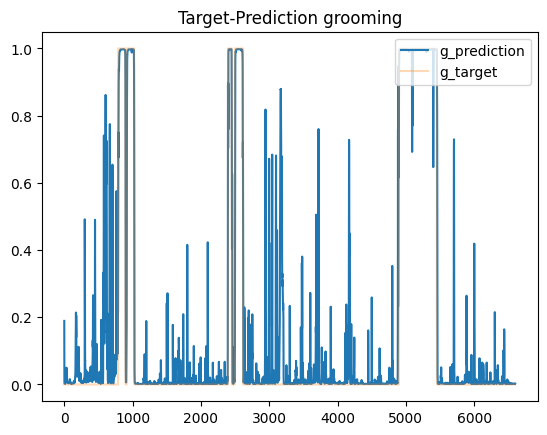

mid_rearing


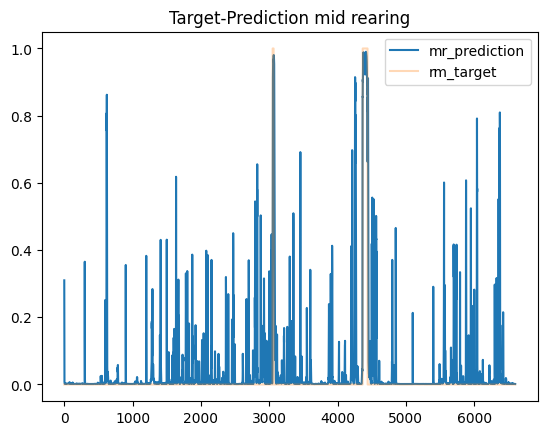

wall_rearing


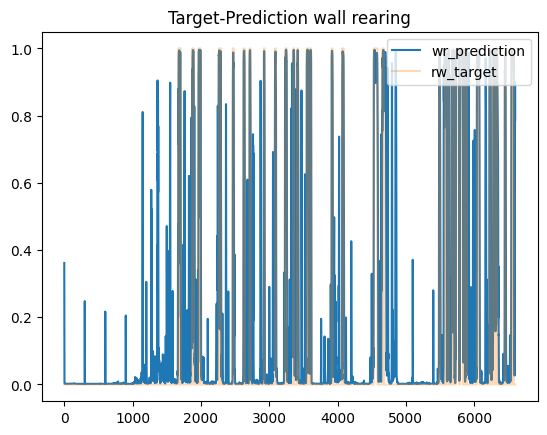

In [109]:
# let's plot some double histograms for each behaviour
for b in behaviours: 
    print(b)
    if b == "grooming":
        plt.plot(results['g_prediction'],  
        alpha=1,
        label='g_prediction') 
        plt.plot(results['grooming'],  
        alpha=0.3,
        label='g_target') 
        plt.legend(loc='upper right') 
        plt.title('Target-Prediction grooming') 
        plt.show()
    elif b == "mid_rearing":
        plt.plot(results['mr_prediction'],  
        alpha=1,
        label='mr_prediction') 
        plt.plot(results['rearing_mig'],  
        alpha=0.3,
        label='rm_target') 
        plt.legend(loc='upper right') 
        plt.title('Target-Prediction mid rearing') 
        plt.show()
    elif b == "wall_rearing":
        plt.plot(results['wr_prediction'],  
        alpha=1,
        label='wr_prediction') 
        plt.plot(results['rearing_paret'],  
        alpha=0.3,
        label='rw_target') 
        plt.legend(loc='upper right') 
        plt.title('Target-Prediction wall rearing') 
        plt.show()


At a first glance, it seems that 0.8 would work well as a threshold for all the 3 classes, eventhought, we will plot some more stadistics to make sure. 

In [110]:
print(results.groupby('grooming')['g_prediction'].describe())
print(results.groupby('rearing_mig')['mr_prediction'].describe())
print(results.groupby('rearing_paret')['wr_prediction'].describe())

           count      mean       std       min       25%       50%       75%  \
grooming                                                                       
0         5652.0  0.037690  0.114917  0.001630  0.002607  0.004225  0.014499   
1          948.0  0.982788  0.073144  0.068646  0.996406  0.997490  0.997827   

               max  
grooming            
0         0.988947  
1         0.998115  
              count      mean       std       min       25%       50%  \
rearing_mig                                                             
0            6513.0  0.029589  0.099764  0.001266  0.001795  0.002765   
1              87.0  0.925593  0.108016  0.292776  0.928457  0.945284   

                  75%       max  
rearing_mig                      
0            0.008637  0.980420  
1            0.977799  0.990148  
                count      mean       std       min       25%       50%  \
rearing_paret                                                             
0              5

We can experiment by setting 2 different thresholds, 0.5 and 0.8, and see which one gives us better results. 

### Setting thresholds and argmax

We will transalte the predictions results in 0's and 1's. For that, we will define our 2 different thresholds and an argmax.

##### Threshold = 0.5

In [111]:
thershold = 0.5
results05 = results.copy()

results05['g_result'] = results05['g_prediction']
results05['mr_result'] = results05['mr_prediction']
results05['wr_result'] = results05['wr_prediction']

# If value lower than 0.5, write 0 
results05.loc[results05['g_prediction'] < thershold,'g_result'] = 0
results05.loc[results05['mr_prediction'] < thershold,'mr_result'] = 0
results05.loc[results05['wr_prediction'] < thershold,'wr_result'] = 0

for ind,row in results05.iterrows():
    # Get the only columns we want to use
    row2 = row[['g_result', 'mr_result', 'wr_result']]
    if max(row2) != 0:
        action = np.argmax(row2) # Get index column with max value
        if action == 0:
            row['g_result'] = 1
            row[['mr_result', 'wr_result']] = 0
            results05.iloc[ind] = row
        elif action == 1:
            row['mr_result'] = 1
            row[['g_result', 'wr_result']] = 0
            results05.iloc[ind] = row
        elif action == 2:
            row['wr_result'] = 1
            row[['mr_result', 'g_result']] = 0
            results05.iloc[ind] = row

In [112]:
results05

,Unnamed: 0,grooming,rearing_mig,rearing_paret,g_prediction,mr_prediction,wr_prediction,g_result,mr_result,wr_result
0,0,0,0,0,0.189215,0.309929,0.361722,0.0,0.0,0.0
1,1,0,0,0,0.026409,0.091716,0.131461,0.0,0.0,0.0
2,2,0,0,0,0.007202,0.021221,0.028782,0.0,0.0,0.0
3,3,0,0,0,0.003865,0.007953,0.008546,0.0,0.0,0.0
4,4,0,0,0,0.002932,0.004627,0.004044,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
6595,6595,0,0,0,0.002130,0.001532,0.689989,0.0,0.0,1.0
6596,6596,0,0,0,0.002418,0.001483,0.872331,0.0,0.0,1.0
6597,6597,0,0,0,0.002684,0.001429,0.899720,0.0,0.0,1.0
6598,6598,0,0,0,0.003144,0.001420,0.890191,0.0,0.0,1.0


##### Threshold = 0.8

In [199]:
thershold = 0.8
results08 = results.copy()

results08['g_result'] = results08['g_prediction']
results08['mr_result'] = results08['mr_prediction']
results08['wr_result'] = results08['wr_prediction']

# If value lower than 0.5, write 0 
results08.loc[results08['g_prediction'] < thershold,'g_result'] = 0
results08.loc[results08['mr_prediction'] < thershold,'mr_result'] = 0
results08.loc[results08['wr_prediction'] < thershold,'wr_result'] = 0

for ind,row in results08.iterrows():
    # Getresults08 the only columns we want to use
    row2 = row[['g_result', 'mr_result', 'wr_result']]
    if max(row2) != 0:
        action = np.argmax(row2) # Get index column with max value
        if action == 0:
            row['g_result'] = 1
            row[['mr_result', 'wr_result']] = 0
            results08.iloc[ind] = row
        elif action == 1:
            row['mr_result'] = 1
            row[['g_result', 'wr_result']] = 0
            results08.iloc[ind] = row
        elif action == 2:
            row['wr_result'] = 1
            row[['mr_result', 'g_result']] = 0
            results08.iloc[ind] = row

In [114]:
results08

,Unnamed: 0,grooming,rearing_mig,rearing_paret,g_prediction,mr_prediction,wr_prediction,g_result,mr_result,wr_result
0,0,0,0,0,0.189215,0.309929,0.361722,0.0,0.0,0.0
1,1,0,0,0,0.026409,0.091716,0.131461,0.0,0.0,0.0
2,2,0,0,0,0.007202,0.021221,0.028782,0.0,0.0,0.0
3,3,0,0,0,0.003865,0.007953,0.008546,0.0,0.0,0.0
4,4,0,0,0,0.002932,0.004627,0.004044,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
6595,6595,0,0,0,0.002130,0.001532,0.689989,0.0,0.0,0.0
6596,6596,0,0,0,0.002418,0.001483,0.872331,0.0,0.0,1.0
6597,6597,0,0,0,0.002684,0.001429,0.899720,0.0,0.0,1.0
6598,6598,0,0,0,0.003144,0.001420,0.890191,0.0,0.0,1.0


### Evaluating models

Now that we have results for both thersholds, let's see which gave better results.

In [267]:
evaulation = pd. DataFrame(0.0, index=np.arange(len(results)), columns=['rmse05', 'rmse08','rmse_result'])
evaulation.head()

,rmse05,rmse08,rmse_result
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [268]:
# We can start by evaluating the RMSE of the predicted results and the real ones.
from sklearn.metrics import mean_squared_error

for ind,row in results05.iterrows():
    evaulation.iloc[ind]['rmse05'] = mean_squared_error(results05[['grooming', 'rearing_mig', 'rearing_paret']].iloc[ind], results05[['g_result','mr_result', 'wr_result']].iloc[ind], squared=True)
    evaulation.iloc[ind]['rmse08'] = mean_squared_error(results08[['grooming', 'rearing_mig', 'rearing_paret']].iloc[ind], results08[['g_result','mr_result', 'wr_result']].iloc[ind], squared=True)

In [126]:
evaulation['rmse05'].unique()

array([0.        , 0.33333333])

In [127]:
evaulation['rmse08'].unique()

array([0.        , 0.33333333])

In [138]:
print('Threshold 05:  Correct = ', len(evaulation[evaulation['rmse05'] == 0]), ', Incorrect = ', evaulation.shape[0] -len(evaulation[evaulation['rmse05'] == 0]))
print('Threshold 08:  Correct = ', len(evaulation[evaulation['rmse08'] == 0]), ', Incorrect = ', evaulation.shape[0] -len(evaulation[evaulation['rmse08'] == 0]))

Threshold 05:  Correct =  6050 , Incorrect =  550
Threshold 08:  Correct =  6304 , Incorrect =  296


Threshold 0.8 works better.

In [221]:
results[['g_result','mr_result', 'wr_result']] = results08[['g_result','mr_result', 'wr_result']]
results

,grooming,rearing_mig,rearing_paret,g_prediction,mr_prediction,wr_prediction,g_result,mr_result,wr_result,0.0,1.0
0,0,0,0,0.189215,0.309929,0.361722,0.0,0.0,0.0,0,0
1,0,0,0,0.026409,0.091716,0.131461,0.0,0.0,0.0,0,0
2,0,0,0,0.007202,0.021221,0.028782,0.0,0.0,0.0,0,0
3,0,0,0,0.003865,0.007953,0.008546,0.0,0.0,0.0,0,0
4,0,0,0,0.002932,0.004627,0.004044,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6595,0,0,0,0.002130,0.001532,0.689989,0.0,0.0,0.0,0,0
6596,0,0,0,0.002418,0.001483,0.872331,0.0,0.0,1.0,0,0
6597,0,0,0,0.002684,0.001429,0.899720,0.0,0.0,1.0,0,0
6598,0,0,0,0.003144,0.001420,0.890191,0.0,0.0,1.0,0,0


### Squence evaulation and treatment 

We will also evaluate how behaviour sequences work and treat them enough to improve the result.

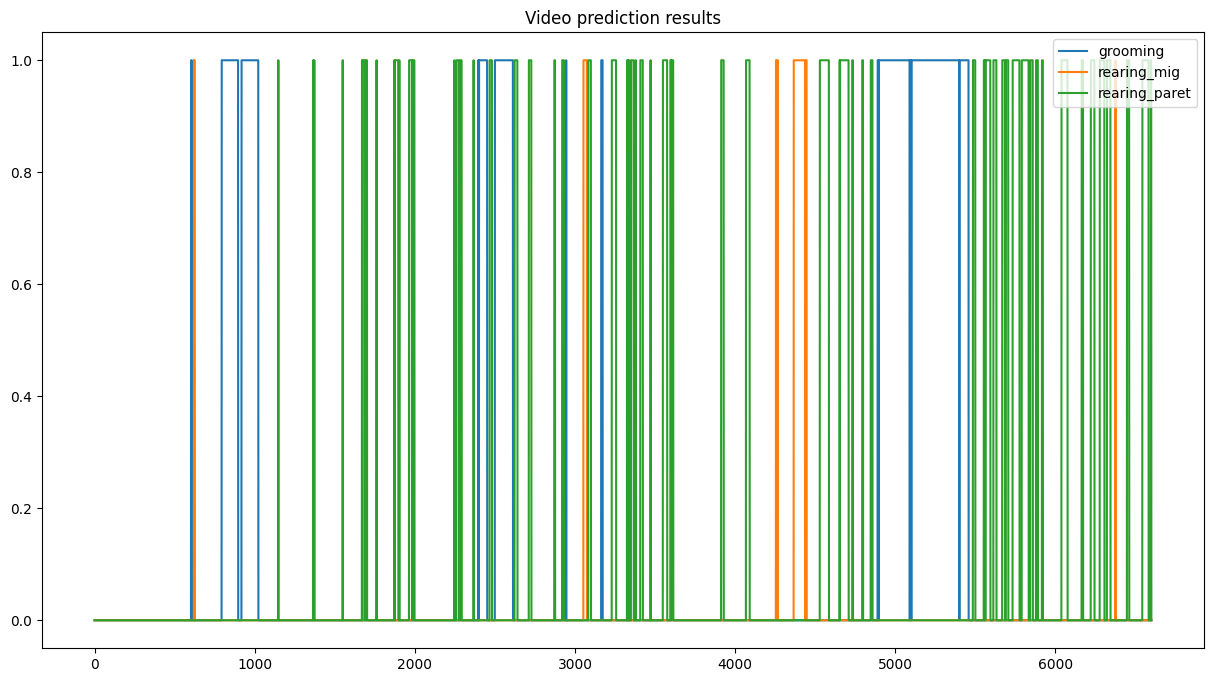

In [222]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(results[['g_result','mr_result', 'wr_result']],  
        label=['grooming', 'rearing_mig', 'rearing_paret']) 
plt.title('Video prediction results') 
plt.legend(loc='upper right') 
plt.show()

In [225]:
# If either the frame on the left or the frame on the right is equal, or if not we will consider that frame a classification error and mark it as 0
for ind,row in results.iterrows():
    if max(results.iloc[ind][['g_result','mr_result', 'wr_result']]) == 1:
        # If we are on the first row
        if ind == 0:
            if max(results.iloc[ind+1][['g_result','mr_result', 'wr_result']]) == 0:
                results[results.iloc[ind]['g_result']] = 0
                results[results.iloc[ind]['mr_result']] = 0
                results[results.iloc[ind]['wr_result']] = 0
            elif max(results.iloc[ind+2][['g_result','mr_result', 'wr_result']]) == 0:
                results[results.iloc[ind]['g_result']] = 0
                results[results.iloc[ind]['mr_result']] = 0
                results[results.iloc[ind]['wr_result']] = 0
                
        # If we are on the last row
        elif ind == len(results)-1:
            if max(results.iloc[ind-1][['g_result','mr_result', 'wr_result']]) == 0:
                results[results.iloc[ind]['g_result']] = 0
                results[results.iloc[ind]['mr_result']] = 0
                results[results.iloc[ind]['wr_result']] = 0
            elif max(results.iloc[ind-2][['g_result','mr_result', 'wr_result']]) == 0:
                results[results.iloc[ind]['g_result']] = 0
                results[results.iloc[ind]['mr_result']] = 0
                results[results.iloc[ind]['wr_result']] = 0
                
         # If we are on the last row
        elif ind == len(results)-2:
            if max(results.iloc[ind-1][['g_result','mr_result', 'wr_result']]) == 0:
                results[results.iloc[ind]['g_result']] = 0
                results[results.iloc[ind]['mr_result']] = 0
                results[results.iloc[ind]['wr_result']] = 0
            elif max(results.iloc[ind-2][['g_result','mr_result', 'wr_result']]) == 0:
                results[results.iloc[ind]['g_result']] = 0
                results[results.iloc[ind]['mr_result']] = 0
                results[results.iloc[ind]['wr_result']] = 0
                
        else:
            if max(results.iloc[ind-1][['g_result','mr_result', 'wr_result']]) == 0 and max(results.iloc[ind+1][['g_result','mr_result', 'wr_result']]) == 0:
                results[results.iloc[ind]['g_result']] = 0
                results[results.iloc[ind]['mr_result']] = 0
                results[results.iloc[ind]['wr_result']] = 0
            elif max(results.iloc[ind-2][['g_result','mr_result', 'wr_result']]) == 0 and max(results.iloc[ind+2][['g_result','mr_result', 'wr_result']]) == 0:
                results[results.iloc[ind]['g_result']] = 0
                results[results.iloc[ind]['mr_result']] = 0
                results[results.iloc[ind]['wr_result']] = 0
                
    else:
         # If we are on the first row       
        if ind == 0:
            if max(results.iloc[ind+1][['g_result','mr_result', 'wr_result']]) == 1:
                results[results.iloc[ind]['g_result']] = results.iloc[ind+1]['g_result']
                results[results.iloc[ind]['mr_result']] = results.iloc[ind+1]['mr_result']
                results[results.iloc[ind]['wr_result']] = results.iloc[ind+1]['wr_result']
            elif max(results.iloc[ind+2][['g_result','mr_result', 'wr_result']]) == 1:
                results[results.iloc[ind]['g_result']] = results.iloc[ind+1]['g_result']
                results[results.iloc[ind]['mr_result']] = results.iloc[ind+1]['mr_result']
                results[results.iloc[ind]['wr_result']] = results.iloc[ind+1]['wr_result']
                
        # If we are on the last row
        elif ind == len(results)-1:
            if max(results.iloc[ind-1][['g_result','mr_result', 'wr_result']]) == 1:
                results[results.iloc[ind]['g_result']] = results.iloc[ind-1]['g_result']
                results[results.iloc[ind]['mr_result']] = results.iloc[ind-1]['mr_result']
                results[results.iloc[ind]['wr_result']] = results.iloc[ind-1]['wr_result']
            elif max(results.iloc[ind-2][['g_result','mr_result', 'wr_result']]) == 1:
                results[results.iloc[ind]['g_result']] = results.iloc[ind-1]['g_result']
                results[results.iloc[ind]['mr_result']] = results.iloc[ind-1]['mr_result']
                results[results.iloc[ind]['wr_result']] = results.iloc[ind-1]['wr_result']
                
        # If we are on the 2nd last row
        elif ind == len(results)-2:
            if max(results.iloc[ind-1][['g_result','mr_result', 'wr_result']]) == 1:
                results[results.iloc[ind]['g_result']] = results.iloc[ind-1]['g_result']
                results[results.iloc[ind]['mr_result']] = results.iloc[ind-1]['mr_result']
                results[results.iloc[ind]['wr_result']] = results.iloc[ind-1]['wr_result']
            elif max(results.iloc[ind-2][['g_result','mr_result', 'wr_result']]) == 1:
                results[results.iloc[ind]['g_result']] = results.iloc[ind-1]['g_result']
                results[results.iloc[ind]['mr_result']] = results.iloc[ind-1]['mr_result']
                results[results.iloc[ind]['wr_result']] = results.iloc[ind-1]['wr_result']
                
        else:
            if max(results.iloc[ind-1][['g_result','mr_result', 'wr_result']]) == 1 and max(results.iloc[ind+1][['g_result','mr_result', 'wr_result']]) == 1:
                results[results.iloc[ind]['g_result']] = results.iloc[ind+1]['g_result']
                results[results.iloc[ind]['mr_result']] = results.iloc[ind+1]['mr_result']
                results[results.iloc[ind]['wr_result']] = results.iloc[ind+1]['wr_result']
            elif max(results.iloc[ind-2][['g_result','mr_result', 'wr_result']]) == 1 and max(results.iloc[ind+2][['g_result','mr_result', 'wr_result']]) == 1:
                results[results.iloc[ind]['g_result']] = results.iloc[ind+1]['g_result']
                results[results.iloc[ind]['mr_result']] = results.iloc[ind+1]['mr_result']
                results[results.iloc[ind]['wr_result']] = results.iloc[ind+1]['wr_result']

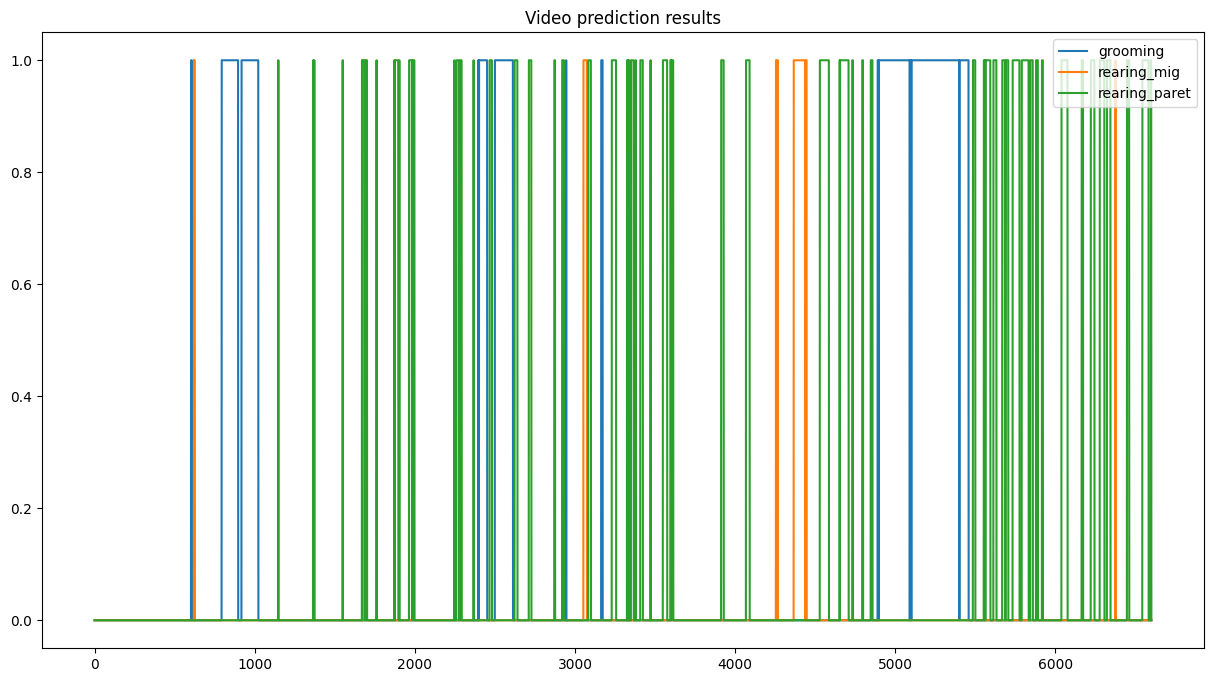

In [226]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(results[['g_result','mr_result', 'wr_result']],  
        label=['grooming', 'rearing_mig', 'rearing_paret']) 
plt.title('Video prediction results') 
plt.legend(loc='upper right') 
plt.show()

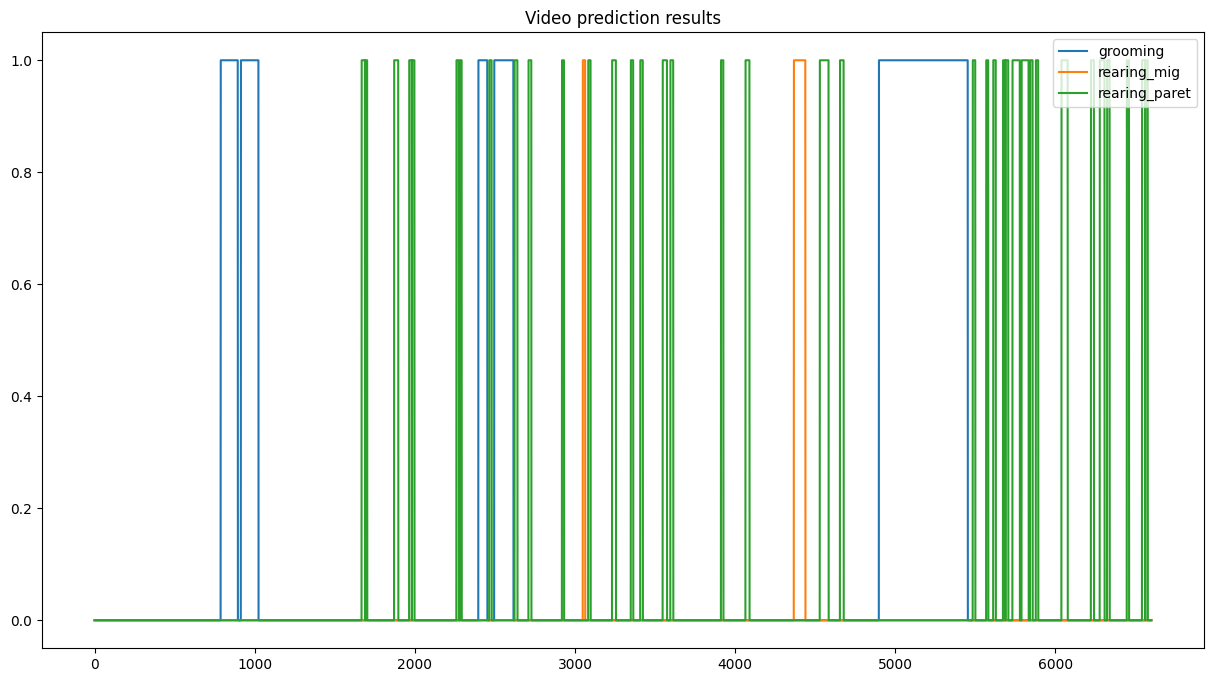

In [157]:
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(results08[['grooming', 'rearing_mig', 'rearing_paret']],  
        label=['grooming', 'rearing_mig', 'rearing_paret']) 
plt.title('Video prediction results') 
plt.legend(loc='upper right') 
plt.show()

In [231]:
evaulation

,rmse05,rmse08
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
...,...,...
6595,0.333333,0.000000
6596,0.333333,0.333333
6597,0.333333,0.333333
6598,0.333333,0.333333


In [269]:
for ind,row in results.iterrows():
    evaulation.iloc[ind]['rmse_result'] =  mean_squared_error(results[['grooming', 'rearing_mig', 'rearing_paret']].iloc[ind], results[['g_result','mr_result', 'wr_result']].iloc[ind], squared=True)

In [270]:
evaulation

,rmse05,rmse08,rmse_result
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000
...,...,...,...
6595,0.333333,0.000000,0.000000
6596,0.333333,0.333333,0.333333
6597,0.333333,0.333333,0.333333
6598,0.333333,0.333333,0.333333


In [271]:
print('Threshold 08:  Correct = ', len(evaulation[evaulation['rmse08'] == 0]), ', Incorrect = ', evaulation.shape[0] -len(evaulation[evaulation['rmse08'] == 0]))
print('Result:  Correct = ', len(evaulation[evaulation['rmse_result'] == 0]), ', Incorrect = ', evaulation.shape[0] -len(evaulation[evaulation['rmse_result'] == 0]))

Threshold 08:  Correct =  6304 , Incorrect =  296
Result:  Correct =  6304 , Incorrect =  296


Results are the same, therefor we can suppose our models perform well in a sense that they consider sequences.